https://colab.research.google.com/drive/1bPYIOxmm_6eeR0U0sVpKXQYTHS009fB9

# Import

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Create Test and Train Data

### Download Data

In [15]:
url = 'https://raw.githubusercontent.com/elymsyr/iris-recognition/main/Project/kp_classify_blur.csv'

df = pd.read_csv(url)

# df = pd.read_csv('kp_classify_blur.csv')
df.head()

,match,image_tag,pos,point_x,point_y,size,angle,response,octave,blur
0,0,S6722S03,right-side,45,111,31.000000,28.460091,0.000393,0,11.132859
1,0,S6735S09,right-side,53,118,44.640003,8.228042,0.000368,2,19.968516
2,0,S6722S03,left-side,46,131,44.640003,169.835007,0.000731,2,11.132859
3,0,S6735S09,left-side,42,75,37.200001,2.890326,0.000027,1,19.968516
4,0,S6722S03,left-side,32,74,31.000000,215.737335,0.000347,0,11.132859


### Process Data

In [16]:
# dividing the datasets into two parts i.e. training datasets and test datasets
mapping = {'right-side': 0, 'left-side': 1, 'bottom': 2, 'complete': 3}
df['pos'] = df['pos'].map(mapping)

# df = df.sample(n=400000, random_state=42).reset_index(drop=True)
df = df.drop(['octave'], axis=1)

In [17]:
df.shape

(813156, 9)

In [18]:
# Separate majority and minority classes
df_class_0 = df[df['match'] == 0]
df_class_1 = df[df['match'] == 1]

# Determine the number of samples to keep
n_samples = min(len(df_class_0), len(df_class_1))

# Undersample the majority class
df_class_0_balanced = df_class_0.sample(n=n_samples, random_state=42)
df_class_1_balanced = df_class_1.sample(n=n_samples, random_state=42)

# Combine the balanced classes
df_balanced = pd.concat([df_class_0_balanced, df_class_1_balanced])

# Shuffle the data
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
print(df['match'].value_counts())

match
0    333688
1    333688
Name: count, dtype: int64


In [20]:
y = df['match']
X = df.drop(labels=['match', 'image_tag'], axis=1)

print(y[:2])
print(X[:2])

0    0
1    0
Name: match, dtype: int64
   pos  point_x  point_y       size       angle  response      blur
0    1       67      122  53.568005  200.405029  0.000824  3.910889
1    3       42       50  31.000000  204.192581  0.000027  4.731988


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

# Train Model

In [22]:
threshold=0.5

## XGBoost

### Train

In [ ]:
import xgboost as xgb

def XGBoost(X_train, X_test, y_train, y_test, model_path='xgboost_model.json', threshold: float = 0.5, params: dict = { 'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 1, 'alpha': 0, 'seed': 4 }):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled data to DMatrix format (optimized for XGBoost)
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)

    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dtest, 'test')], early_stopping_rounds=100, verbose_eval=10)

    # Predict
    y_pred = bst.predict(dtest)
    predictions = [1 if x > threshold else 0 for x in y_pred]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    bst.save_model(model_path)

    # Return the model and metrics
    return bst, accuracy, auc, y_pred, predictions, dtrain, dtest


In [11]:
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  # Evaluation metric, AUC is a common choice
    'eta': 0.1,  # Learning rate
    'max_depth': 10,  # Maximum depth of a tree
    'min_child_weight': 1,  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'lambda': 1,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weights
    'seed': 42  # Random seed for reproducibility
}

In [ ]:
bst, accuracy, auc, y_pred, predictions, dtrain, dtest = XGBoost(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

In [ ]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))

In [ ]:
plot_importance(bst)
plt.show()

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the model
model = XGBClassifier(eval_metric='auc')

param_grid = {
    'objective': ['binary:logistic'],  # Keeping it for binary classification
    'eval_metric': ['auc'],  # AUC is a common evaluation metric
    'learning_rate': [0.1],  # Learning rate (eta), typically small
    'max_depth': [None, 12],  # Depth of trees; small to moderate values to prevent overfitting
    'min_child_weight': [1, 3],  # Minimum sum of instance weight needed in a child; values to regularize
    # 'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances; controlling overfitting
    # 'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.5, 1.0],  # Minimum loss reduction required to make a further partition
    # 'reg_lambda': [1, 10, 100],  # L2 regularization term on weights
    # 'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'n_estimators': [200, 300],  # Number of trees to fit; affects model complexity
    'scale_pos_weight': [2],  # Balances positive and negative weights in unbalanced datasets
    'seed': [42]  # Random seed for reproducibility
}

# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

In [ ]:
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

# Access the full results in a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display the top 5 results sorted by mean test score
print("Top 5 parameter combinations:")
print(results_df[['mean_test_score', 'std_test_score', 'rank_test_score', 'mean_score_time']].sort_values(by='mean_test_score', ascending=False).head())
# print(results_df[['params']])

# Additional details: display all columns available
# print("\nColumns available in cv_results_:\n", results_df.columns)

## LightGBM

In [26]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

def LightGBM(X_train, X_test, y_train, y_test, model_path='lightgbm_model.txt', threshold=0.5, params=None):
    # Default parameters for LightGBM
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.1,
            'max_depth': 10,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'bagging_fraction': 0.8,
            'feature_fraction': 0.8,
            'lambda_l1': 0.0,
            'lambda_l2': 0.0,
            'seed': 4
        }

    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled data to LightGBM Dataset format
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    test_data = lgb.Dataset(X_test_scaled, label=y_test)

    # Train the model
    model = lgb.train(params, train_data, num_boost_round=300, valid_sets=[test_data])

    # Predict
    y_pred = model.predict(X_test_scaled)
    predictions = [1 if x > threshold else 0 for x in y_pred]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    model.save_model(model_path)

    # Return the model and metrics
    return model, accuracy, auc, y_pred, predictions, train_data, test_data

In [29]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': None,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'seed': 4
}

In [30]:
model, accuracy, auc, y_pred, predictions, train_data, test_data = LightGBM(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

[LightGBM] [Info] Number of positive: 283624, number of negative: 283645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 567269, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499981 -> initscore=-0.000074
[LightGBM] [Info] Start training from score -0.000074
Accuracy: 0.6188
AUC: 0.6683


0.6188278541960103 0.6683201633635661


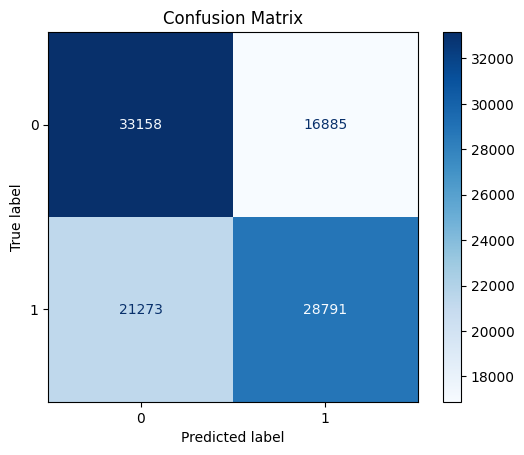

              precision    recall  f1-score   support

           0       0.61      0.66      0.63     50043
           1       0.63      0.58      0.60     50064

    accuracy                           0.62    100107
   macro avg       0.62      0.62      0.62    100107
weighted avg       0.62      0.62      0.62    100107



In [31]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import joblib

def RandomForest(X_train, X_test, y_train, y_test, model_path='random_forest_model.pkl', threshold=0.5, params=None):
    # Default parameters for Random Forest
    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'random_state': 4
        }

    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    predictions = [1 if x > threshold else 0 for x in y_pred_proba]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    joblib.dump(model, model_path)

    # Return the model and metrics
    return model, accuracy, auc, y_pred_proba, predictions


In [34]:
params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 4
}

In [35]:
model, accuracy, auc, y_pred_proba, predictions = RandomForest(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

Accuracy: 0.5891
AUC: 0.6266


0.5890996633602046 0.6265696278685149


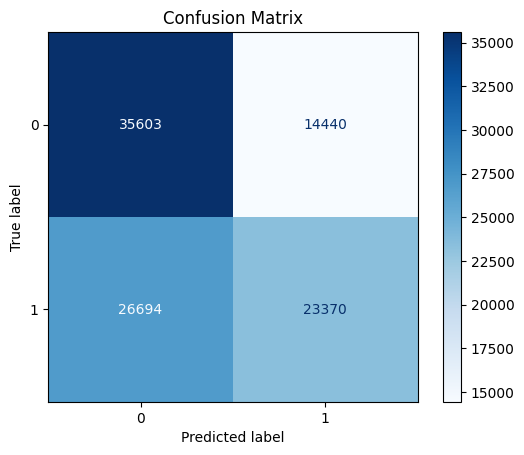

              precision    recall  f1-score   support

           0       0.57      0.71      0.63     50043
           1       0.62      0.47      0.53     50064

    accuracy                           0.59    100107
   macro avg       0.59      0.59      0.58    100107
weighted avg       0.59      0.59      0.58    100107



In [36]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))

## Logistic Regression with Regularization Function

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import joblib

def LogisticRegressionWithRegularization(X_train, X_test, y_train, y_test, model_path='logistic_regression_model.pkl', threshold=0.5, params=None):
    # Default parameters for Logistic Regression
    if params is None:
        params = {
            'penalty': 'l2',  # Regularization
            'C': 1.0,  # Inverse of regularization strength
            'solver': 'lbfgs',
            'max_iter': 1000,
            'random_state': 4
        }

    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    predictions = [1 if x > threshold else 0 for x in y_pred_proba]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    joblib.dump(model, model_path)

    # Return the model and metrics
    return model, accuracy, auc, y_pred_proba, predictions


In [39]:
params = {
    'penalty': 'l2',  # Regularization
    'C': 1.0,  # Inverse of regularization strength
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': 4
}

In [40]:
model, accuracy, auc, y_pred_proba, predictions = LogisticRegressionWithRegularization(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

Accuracy: 0.5639
AUC: 0.5776


0.5638866412938156 0.5776061053058448


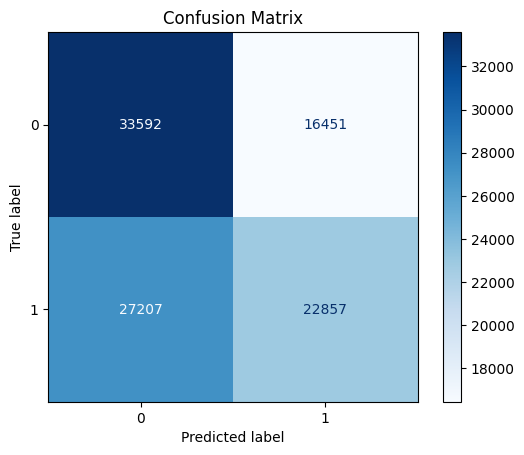

              precision    recall  f1-score   support

           0       0.55      0.67      0.61     50043
           1       0.58      0.46      0.51     50064

    accuracy                           0.56    100107
   macro avg       0.57      0.56      0.56    100107
weighted avg       0.57      0.56      0.56    100107



In [41]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))

## LSTM

In [45]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def LSTMModel(X_train, X_test, y_train, y_test, model_path='lstm_model.h5', threshold=0.5, params=None):
    # Default parameters for LSTM
    if params is None:
        params = {
            'units': 50,
            'dropout_rate': 0.2,
            'epochs': 100,
            'batch_size': 32,
            'validation_split': 0.2,
            'random_state': 4
        }

    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape input to be [samples, time steps, features]
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=params['units'], input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_scaled, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
              validation_split=params['validation_split'], callbacks=[early_stopping], verbose=2)

    # Predict
    y_pred = model.predict(X_test_scaled).ravel()
    predictions = [1 if x > threshold else 0 for x in y_pred]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    model.save(model_path)

    # Return the model and metrics
    return model, accuracy, auc, y_pred, predictions


In [46]:
params = {
    'units': 50,
    'dropout_rate': 0.2,
    'epochs': 100,
    'batch_size': 32,
    'validation_split': 0.2,
    'random_state': 4
}

In [ ]:
model, accuracy, auc, y_pred, predictions = LSTMModel(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

In [ ]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))